<a href="https://colab.research.google.com/github/wockeshuh/CSCI164/blob/main/c166DeepQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.4 MB/s eta 0:00:00


In [ ]:
import random, time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

from tqdm.auto import tqdm

n_episodes = 50 # play 1000 games
eps = 0.8  # exploration rate, probability of choosing random action
eps_decay = 0.9900  # eps gets multiplied by this number each epoch...
min_eps = 0.1  # ...until this minimum eps is reached
gamma = 0.99  # discount
max_memory_size = 10000  # size of the replay memory
batch_size = 16  # batch size of the neural network training
min_length = 160  # minimum length of the replay memory for training, before it reached this length, no gradient updates happen
memory_parts = [
    "state",
    "action",
    "next_state",
    "reward",
    "done",
]  # nice names for the part of replay memory, otherweise the names are 0-5

Num GPUs Available:  0
Num CPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Learning A Model

In [ ]:
Memory = namedtuple("Memory", memory_parts)  # a single entry of the memory replay


class ReplayMemory:
    def __init__(self, max_length=None):
        self.max_length = max_length
        self.memory = deque(maxlen=max_length)

    def store(self, data):
        self.memory.append(data)

    def _sample(self, k):
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        batch = self._sample(k)
        result = {}
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        return result

    def __len__(self):
        return len(self.memory)

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),  # Define input shape with Input layer
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2, activation="linear"),  # 2 actions: go left or go right
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [ ]:
env = gym.make("CartPole-v1")
replay_memory = ReplayMemory(max_length=max_memory_size)

for episode in tqdm(range(n_episodes)):  # tqdm makes a nice proress bar
    state, _ = env.reset()
    done = False

    while not done:
        if random.random() < eps:
            action = env.action_space.sample()  # random action
        else:
            action = model.predict(state[np.newaxis, :], verbose=False).argmax()  # best action according to the model

        next_state, reward, done, _, _ = env.step(action)
        memory = Memory(state, action, next_state, reward, done)
        replay_memory.store(memory)

        if len(replay_memory) >= min_length:
            batch = replay_memory.structured_sample(batch_size)  # get samples from the replay memory

            target_batch = batch["reward"] + gamma * model.predict(batch["next_state"], verbose=False).max(axis=1) * (
                1 - batch["done"]
            )  # R(s, a) + γ·maxₐ N(s') if not a terminal state, otherwise R(s, a)
            targets = model.predict(batch["state"], verbose=False)
            targets[
                range(batch_size), batch["action"]
            ] = target_batch  # set the target for the action that was done and leave the outputs of other 3 actions as they are

            model.fit(batch["state"], targets, verbose=False, batch_size=batch_size)  # train for one epoch

        state = next_state
    if episode % 100 == 0:
      save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
      print (save_path)
      model.save(save_path)
    eps = max(min_eps, eps * eps_decay)
save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
print (save_path)
model.save(save_path)

  0%|          | 0/50 [00:00<?, ?it/s]

/content/drive/My Drive/my_QmodelB_0iterations.keras
/content/drive/My Drive/my_QmodelB_49iterations.keras


In [ ]:
eps_decay = 0.9900
min_eps = 0.01
eps = 1.0
for i in range(50):
  eps = max(min_eps, eps * eps_decay)
  if (i % 10==0):
    print (i, eps)

print(eps)

0 0.99
10 0.8953382542587163
20 0.8097278682212583
30 0.7323033696543974
40 0.6622820409839835
0.6050060671375365


# Test Learned Models

In [ ]:
## Choose Model
version = 1
models = [(0, '1-1ZxkEknQ-_Ru-Z63oaMWiLqaSufW2kz'), (49, '1-1ZxkEknQ-_Ru-Z63oaMWiLqaSufW2kz')]

!gdown {models[version][1]}
save_path=f'my_QmodelB_{models[version][0]}iterations.keras'
print(save_path)

Downloading...
From: https://drive.google.com/uc?id=1-1ZxkEknQ-_Ru-Z63oaMWiLqaSufW2kz
To: /content/my_QmodelB_49iterations.keras
100% 148k/148k [00:00<00:00, 130MB/s]
my_QmodelB_49iterations.keras


In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf

from tensorflow.keras.models import load_model

model = load_model(save_path, compile=False)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

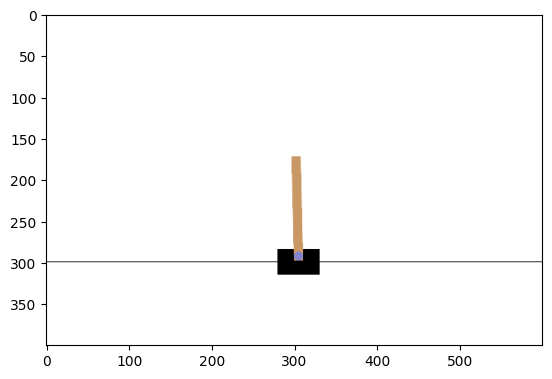

action=1, total_reward=1.0


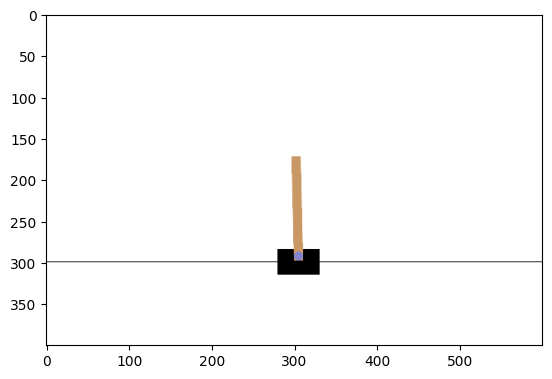

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
state_image=env.render()
plt.imshow(state_image)
plt.show()

state_image=env.render()
action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
state, reward, done, _, _ = env.step(action)
total_reward += reward
print (f"{action=}, {total_reward=}")
state_image=env.render()
plt.imshow(state_image)
plt.show()

In [ ]:
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0

while not done and total_reward < 500:  # force end the game after 500 time steps because the model is too good!
    env.render()
    action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print (f"{total_reward=}")

total_reward=85.0


In [ ]:
env.close()

The first thing I did was reduce the number of episodes. For 1000 episodes it was taking about a hour to compile. I changed the number of episodes to 150. After doing this I was able to get a reward of 69 which wasn't good at all. I decided to reduced it even further to 50 episodes and modified the gamma to see if that would help get a better reward. However, it did not. I think increasing the gamma didn't help because the agent has less time to explore with 50 episodes. I then changed the epsilon decay value to 0.9900. This helped the reward increase from 41 to 85. Lowering the value means the agent explores less. The fact that the reward increased could mean that the agent found a good policy and kept using it.